In [2]:
!pwd
!git clone https://github.com/mbzuai-nlp/M4.git

/kaggle/working
fatal: destination path 'M4' already exists and is not an empty directory.


In [3]:
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import DebertaTokenizer, DebertaForSequenceClassification, AdamW

# Definirea funcției pentru încărcarea și preprocesarea datelor
def load_and_prepare_data(file_paths, tokenizer):
    texts = []
    labels = []
    for file_path in file_paths:
        data = pd.read_json(file_path, lines=True)
        human_texts = data['human_text'].tolist()
        machine_texts = data['machine_text'].tolist()
        texts.extend(human_texts + machine_texts)
        labels.extend([0] * len(human_texts) + [1] * len(machine_texts))
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    return encodings['input_ids'], labels

# Definirea funcției pentru împărțirea datelor în seturi de antrenament, validare și testare
def split_train_data(input_ids, labels, train_size=0.7, test_size=0.2, val_size=0.1):
    X_train, X_temp, y_train, y_temp = train_test_split(input_ids, labels, test_size=(1 - train_size))
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (test_size + val_size)))
    return X_train, y_train, X_val, y_val, X_test, y_test

def split_test_data(input_ids, labels, test_size=0.2):
    _, X_test, _, y_test = train_test_split(input_ids, labels, test_size=test_size)
    return X_test, y_test

# Definirea tokenizatorului
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Încărcarea și împărțirea datelor pentru Reddit ChatGPT (antrenament)
reddit_chatgpt_input_ids, reddit_chatgpt_labels = load_and_prepare_data(['/kaggle/working/M4/data/reddit_chatGPT.jsonl'], tokenizer)
X_train_reddit, y_train_reddit, X_val_reddit, y_val_reddit, X_test_reddit, y_test_reddit = split_train_data(reddit_chatgpt_input_ids, reddit_chatgpt_labels)

# Încărcarea și împărțirea datelor pentru Wikipedia ChatGPT (testare)
wikipedia_chatgpt_input_ids, wikipedia_chatgpt_labels = load_and_prepare_data(['/kaggle/working/M4/data/wikipedia_chatgpt.jsonl'], tokenizer)
X_test_wikipedia, y_test_wikipedia = split_test_data(wikipedia_chatgpt_input_ids, wikipedia_chatgpt_labels)

# Încărcarea și împărțirea datelor pentru Arxiv ChatGPT (testare)
arxiv_chatgpt_input_ids, arxiv_chatgpt_labels = load_and_prepare_data(['/kaggle/working/M4/data/arxiv_chatGPT.jsonl'], tokenizer)
X_test_arxiv, y_test_arxiv = split_test_data(arxiv_chatgpt_input_ids, arxiv_chatgpt_labels)

# Definirea claselor pentru seturile de date și DataLoader
class TextDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# Antrenament, validare și test pentru Reddit ChatGPT
train_dataset_reddit = TextDataset(X_train_reddit, y_train_reddit)
val_dataset_reddit = TextDataset(X_val_reddit, y_val_reddit)
test_dataset_reddit = TextDataset(X_test_reddit, y_test_reddit)

train_loader_reddit = DataLoader(train_dataset_reddit, batch_size=16, shuffle=True)
val_loader_reddit = DataLoader(val_dataset_reddit, batch_size=16, shuffle=False)
test_loader_reddit = DataLoader(test_dataset_reddit, batch_size=16, shuffle=False)

# Test pentru Wikipedia ChatGPT
test_dataset_wikipedia = TextDataset(X_test_wikipedia, y_test_wikipedia)
test_loader_wikipedia = DataLoader(test_dataset_wikipedia, batch_size=16, shuffle=False)

# Test pentru Arxiv ChatGPT
test_dataset_arxiv = TextDataset(X_test_arxiv, y_test_arxiv)
test_loader_arxiv = DataLoader(test_dataset_arxiv, batch_size=16, shuffle=False)

from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definirea modelului și a optimizer-ului
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Funcția de antrenare și validare
def train(model, train_loader, val_loader, optimizer, num_epochs=3):
    train_losses = []
    val_losses = []
    val_metrics = []
    
    for epoch in range(num_epochs):
        # Antrenare
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validare
        model.eval()
        total_val_loss = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()
                predictions = outputs.logits.argmax(dim=-1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
        roc_auc = roc_auc_score(all_labels, all_predictions)
        val_metrics.append((accuracy, precision, recall, f1, roc_auc))
        
        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.4f}, Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}, Val ROC-AUC: {roc_auc:.4f}')
    
    return train_losses, val_losses, val_metrics

train_losses, val_losses, val_metrics = train(model, train_loader_reddit, val_loader_reddit, optimizer, num_epochs=3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=T

Epoch 1: Train Loss: 0.1349, Val Loss: 0.0270, Val Accuracy: 0.9950, Val Precision: 0.9904, Val Recall: 1.0000, Val F1: 0.9952, Val ROC-AUC: 0.9949


  0%|          | 0/263 [00:00<?, ?it/s]/tmp/ipykernel_34/1896647552.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
100%|██████████| 263/263 [01:09<00:00,  3.80it/s]


Epoch 2: Train Loss: 0.0431, Val Loss: 0.0395, Val Accuracy: 0.9850, Val Precision: 0.9902, Val Recall: 0.9805, Val F1: 0.9853, Val ROC-AUC: 0.9851


  0%|          | 0/263 [00:00<?, ?it/s]/tmp/ipykernel_34/1896647552.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
100%|██████████| 263/263 [01:09<00:00,  3.79it/s]


Epoch 3: Train Loss: 0.0185, Val Loss: 0.1800, Val Accuracy: 0.9567, Val Precision: 0.9222, Val Recall: 1.0000, Val F1: 0.9595, Val ROC-AUC: 0.9555


/tmp/ipykernel_34/1896647552.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/tmp/ipykernel_34/1896647552.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/tmp/ipykernel_34/1896647552.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),


Test Reddit - Accuracy: 0.9600, Precision: 0.9253, Recall: 1.0000, F1: 0.9612, ROC-AUC: 0.9604
Test Wikipedia - Accuracy: 0.5868, Precision: 0.5508, Recall: 1.0000, F1: 0.7104, ROC-AUC: 0.5812
Test Arxiv - Accuracy: 0.8467, Precision: 0.7626, Recall: 1.0000, F1: 0.8653, ROC-AUC: 0.8489


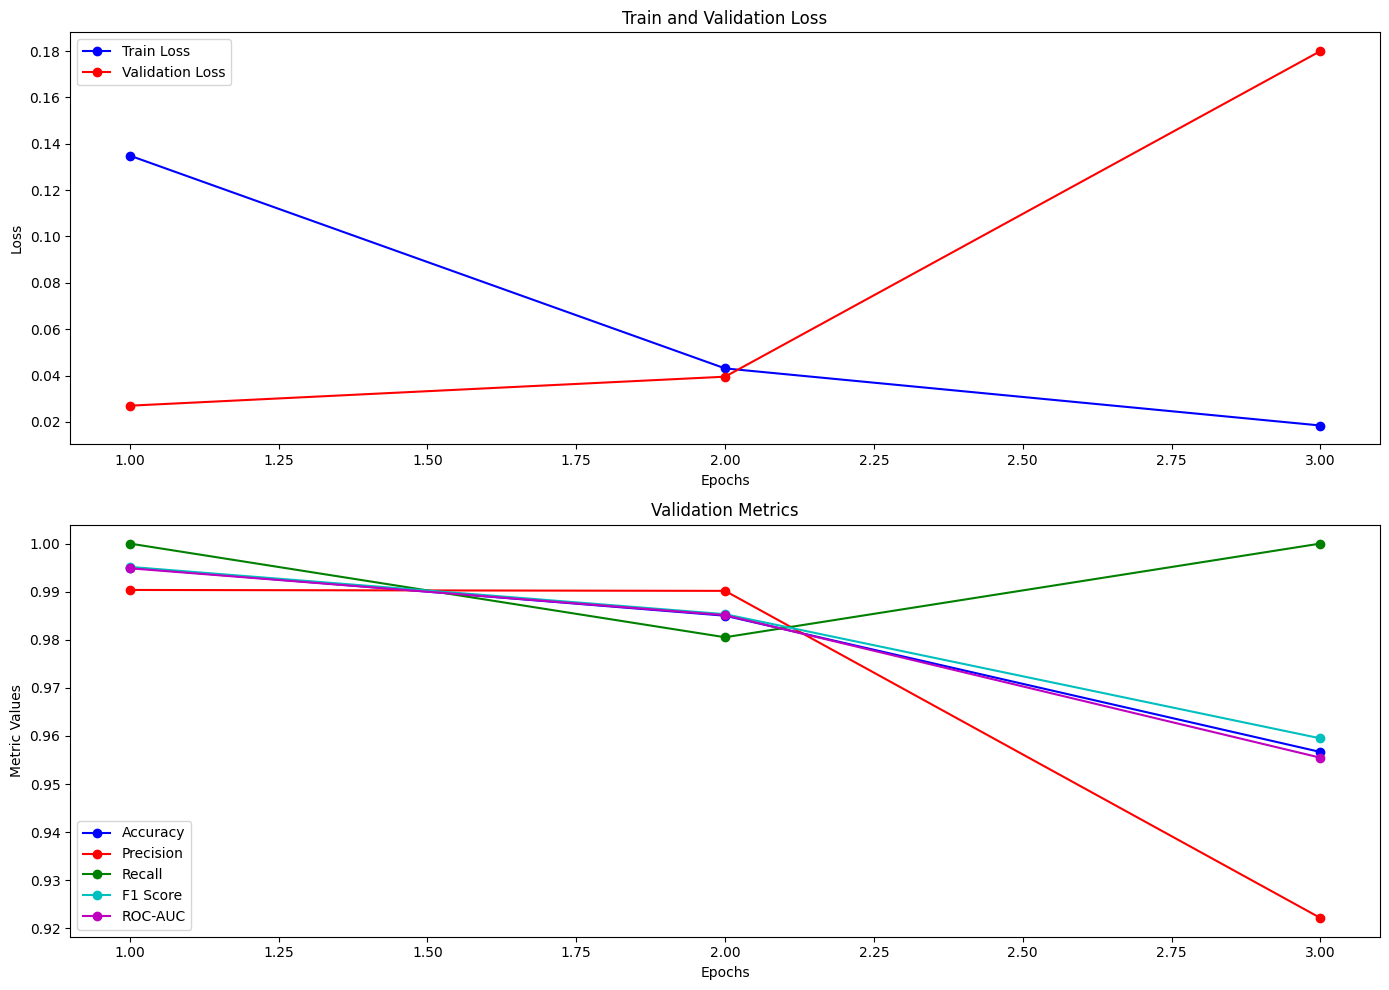

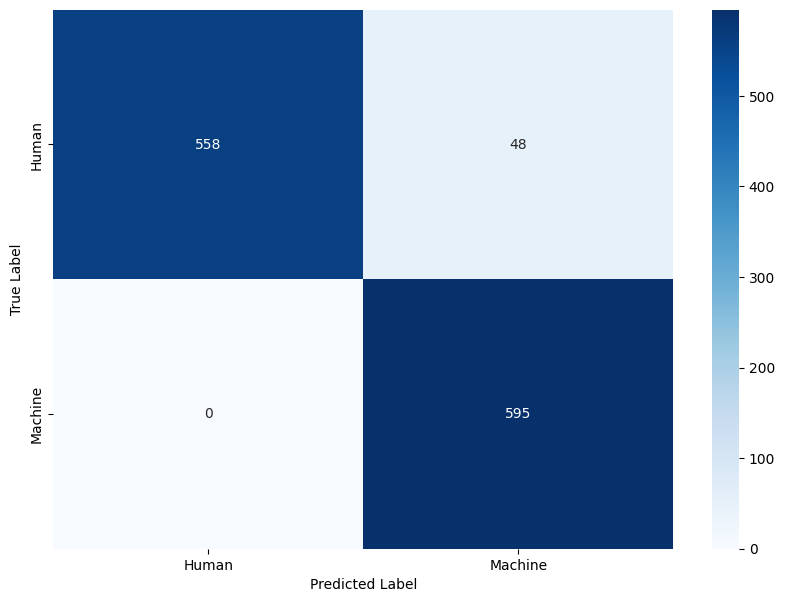

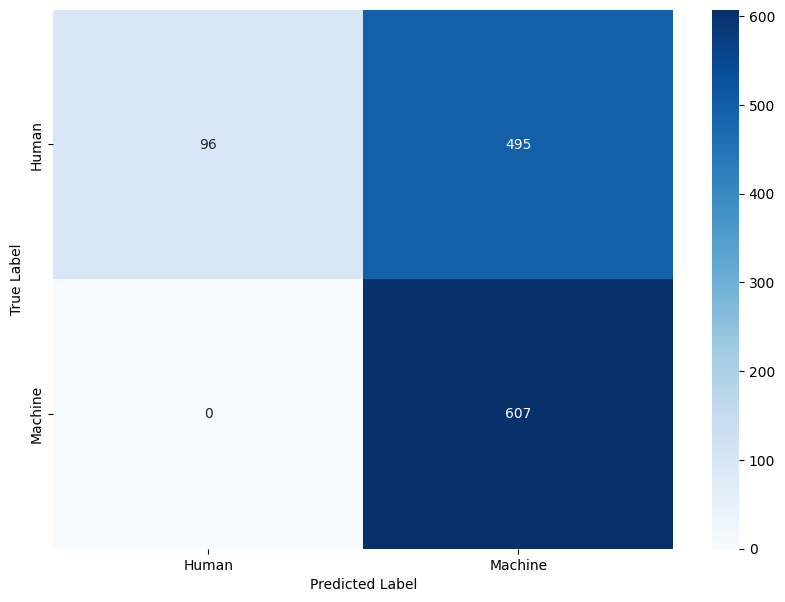

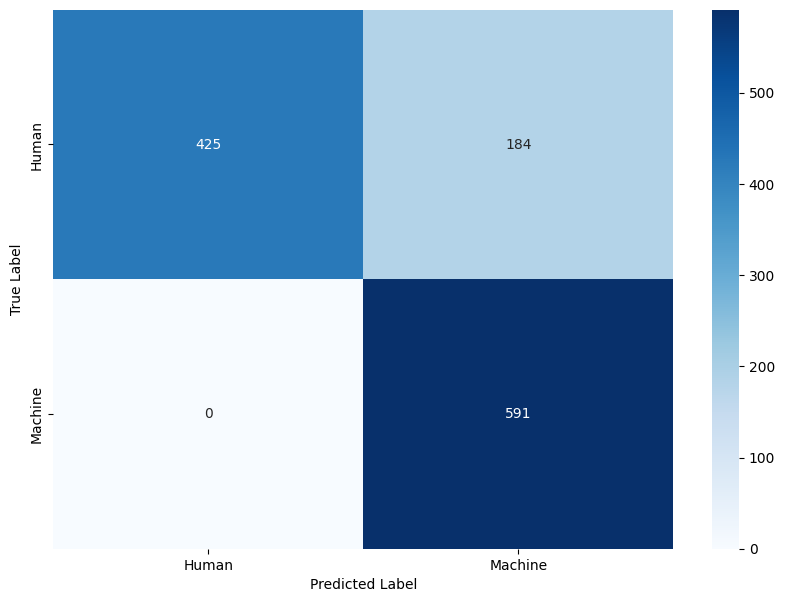

Misclassified Examples from Reddit:
True Label: 0, Predicted Label: 1, Text: Star Wars was almost perfectly constructed for success in many different ways, and this is actually a good historical question because the reasons behind this have a rich history.

Let's start with scifi as a genre. Beginning in the late 19th century with authors such as Jules Verne, H.G. Wells, and others science fiction came into being as a substantial and widely popular literary genre. Through the early to mid 20th century a huge number of new and talented authors brought the genre to substantial heights of legitimacy and sophistication by presenting an ever growing and highly varied selection of imaginative worlds, characters, and circumstances. A
True Label: 0, Predicted Label: 1, Text: The HST was designed according to the limitations of spacecraft and telescope engineering and technology at the time. It uses a monolithic mirror which shares a fundamental design heritage going all the way back to Newton'

In [4]:
# Salvăm ponderile modelului
model_path = '/kaggle/working/bert_model_reddit_chatgpt.pth'
torch.save(model.state_dict(), model_path)

# Încărcăm ponderile modelului pentru testare
model.load_state_dict(torch.load(model_path))
model.to(device)

# Funcția de evaluare
def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            predictions = outputs.logits.argmax(dim=-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    roc_auc = roc_auc_score(all_labels, all_predictions)
    return accuracy, precision, recall, f1, roc_auc, all_labels, all_predictions

# Testare pe setul Reddit
accuracy_reddit, precision_reddit, recall_reddit, f1_reddit, roc_auc_reddit, all_labels_reddit, all_predictions_reddit = evaluate(model, test_loader_reddit)
# Testare pe setul Wikipedia
accuracy_wikipedia, precision_wikipedia, recall_wikipedia, f1_wikipedia, roc_auc_wikipedia, all_labels_wikipedia, all_predictions_wikipedia = evaluate(model, test_loader_wikipedia)
# Testare pe setul Arxiv
accuracy_arxiv, precision_arxiv, recall_arxiv, f1_arxiv, roc_auc_arxiv, all_labels_arxiv, all_predictions_arxiv = evaluate(model, test_loader_arxiv)

print(f'Test Reddit - Accuracy: {accuracy_reddit:.4f}, Precision: {precision_reddit:.4f}, Recall: {recall_reddit:.4f}, F1: {f1_reddit:.4f}, ROC-AUC: {roc_auc_reddit:.4f}')
print(f'Test Wikipedia - Accuracy: {accuracy_wikipedia:.4f}, Precision: {precision_wikipedia:.4f}, Recall: {recall_wikipedia:.4f}, F1: {f1_wikipedia:.4f}, ROC-AUC: {roc_auc_wikipedia:.4f}')
print(f'Test Arxiv - Accuracy: {accuracy_arxiv:.4f}, Precision: {precision_arxiv:.4f}, Recall: {recall_arxiv:.4f}, F1: {f1_arxiv:.4f}, ROC-AUC: {roc_auc_arxiv:.4f}')

# Plotarea metricelor și a loss-urilor
def plot_metrics(train_losses, val_losses, val_metrics):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    accuracy, precision, recall, f1, roc_auc = zip(*val_metrics)
    plt.plot(epochs, accuracy, 'b-o', label='Accuracy')
    plt.plot(epochs, precision, 'r-o', label='Precision')
    plt.plot(epochs, recall, 'g-o', label='Recall')
    plt.plot(epochs, f1, 'c-o', label='F1 Score')
    plt.plot(epochs, roc_auc, 'm-o', label='ROC-AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Values')
    plt.title('Validation Metrics')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_metrics)

# Plotarea matricii de confuzie și a exemplelor misclassified
def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'Machine'], yticklabels=['Human', 'Machine'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(all_labels_reddit, all_predictions_reddit)
plot_confusion_matrix(all_labels_wikipedia, all_predictions_wikipedia)
plot_confusion_matrix(all_labels_arxiv, all_predictions_arxiv)

# Exemple misclassified
misclassified_indices_reddit = [i for i, (true, pred) in enumerate(zip(all_labels_reddit, all_predictions_reddit)) if true != pred]
misclassified_examples_reddit = [(all_labels_reddit[i], all_predictions_reddit[i], test_dataset_reddit.input_ids[i]) for i in misclassified_indices_reddit]

print("Misclassified Examples from Reddit:")
for true_label, pred_label, input_ids in misclassified_examples_reddit[:5]:
    text = tokenizer.decode(input_ids, skip_special_tokens=True)
    print(f'True Label: {true_label}, Predicted Label: {pred_label}, Text: {text}')


Wikipedia DaVinci - Test: 1200
